In [1]:
import numpy as np
import pandas as pd
import math
import os
import sys
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap

sys.path.append("..")

from MagneticFluxRopeModels.ECModel import ECModel

## Phase 1: Simulation

We make a sweep of simulations and fittings, and store the results in a csv file.

In [2]:
from collections import namedtuple

ParameterRange = namedtuple("ParameterRange", ["start", "end", "number"])

In [3]:
from scipy.stats import qmc

def create_lhs(variable_ranges: dict[str, tuple[float, float]], n_samples: int):
    """Create a Latin Hypercube Sampling (LHS) of the given variable ranges.

    Args:
        variable_ranges (dict[str, ParameterRange]): Dictionary of variable ranges.
        n_samples (int): Number of samples to generate.

    Returns:
        pd.DataFrame: DataFrame containing the LHS samples.
    """
    variables_to_sweep = list(variable_ranges.keys())
    dims = len(variables_to_sweep)
    sampler = qmc.LatinHypercube(d=dims, seed=1)

    sample = sampler.random(n=n_samples)
    df_sample = pd.DataFrame(sample, columns=variables_to_sweep)

    for var, var_range in variable_ranges.items():
        df_sample[var] = var_range[0] + df_sample[var] * (var_range[1] - var_range[0])

    return df_sample

In [4]:
def save_results(results: dict[str, list], save_folder: str, save_name: str):
    """Save the results to a CSV file.

    Args:
        results (dict[str, list]): Dictionary of results.
        save_folder (str): Folder to save the results.
    """
    df = pd.DataFrame(results)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    df.to_csv(f"{save_folder}/{save_name}.csv", index=False)
    print(f"Saved results to {save_folder}/{save_name}.csv")


def sweep_cc_model_fitting(df_sample: pd.DataFrame, num_repeats: int, noise_type: str = "gaussian", save_folder: str | None = None, save_name: str = "raw_dataset", num_time_stencil: int = 13):
    """Make a sweep of delta and impact parameter (y_0), in which for each pair of parameters, an ECModel magnetic flux rope crossing is simulated,
    together with some gaussian noise. The simulated data is then fitted with another ECModel, and the fitted delta and y_0 parameters are recovered.

    Args:
        noise_level (float): noise level used, as a fraction of B_z_0.
        noise_type (str, optional): type of noise. Defaults to "gaussian".
        n_delta (int, optional): number of samples to split the delta range. Defaults to 10.
        n_y_0 (int, optional): number of samples to split the impact parameter range. Defaults to 10.
        save_folder (str | None, optional): folder where to save the results. Defaults to None.

    Returns:
        _type_: a pandas dataframe with four columns: delta, y_0, delta_opt, y_0_opt.
    """
    results = {"f_opt": [],
               "random_seed": [],
               "noise_level": [],
               "num_repeat": [],
               "num_experiment": []}
    
    for var in df_sample.columns:
        if var != "noise_level":
            results[var] = []
            results[var + "_opt"] = []
    
    for experiment_idx in range(len(df_sample)):
        tau = df_sample["tau"].iloc[experiment_idx]
        y_0 = df_sample["y_0"].iloc[experiment_idx]
        B_z_0 = df_sample["B_z_0"].iloc[experiment_idx]
        C_nm = df_sample["C_nm"].iloc[experiment_idx]
        noise_level = df_sample["noise_level"].iloc[experiment_idx]

        if "delta" in df_sample.columns:
            delta = df_sample["delta"].iloc[experiment_idx]
        else:
            delta = 1.0
        
        if "psi" in df_sample.columns:
            psi = df_sample["psi"].iloc[experiment_idx]
        else:
            psi = 0.0

        # Create the EC model.
        my_ec_model = ECModel(delta=delta, psi=psi, tau=tau, B_z_0=B_z_0, C_nm=C_nm)
        
        for n_repeat in range(num_repeats):
            # Simulate the crossing.
            random_seed = experiment_idx*num_repeats + n_repeat
            df = my_ec_model.simulate_crossing(time_stencil=num_time_stencil, v_sc=450.0, y_0=y_0, noise_type=noise_type, epsilon=noise_level*my_ec_model.B_z_0, random_seed=random_seed)
            
            if df is None:
                continue

            model_params = {
                "tau": {"mode": "optimised", "initial_value": tau, "bounds": [0.1, 2.5]},
                "C_nm": {"mode": "optimised", "initial_value": C_nm, "bounds": [0.05, 2.1]},
                "B_z_0": {"mode": "optimised", "initial_value": B_z_0, "bounds": [1, 20]}
                }
            
            if "delta" in df_sample.columns:
                model_params["delta"] = {"mode": "optimised", "initial_value": delta, "bounds": [0.25, 1]}
            else:
                model_params["delta"] = {"mode": "fixed", "value": delta}
            
            if "psi" in df_sample.columns:
                model_params["psi"] = {"mode": "optimised", "initial_value": psi, "bounds": [1e-3, math.pi - 1e-3]}
            else:
                model_params["psi"] = {"mode": "fixed", "value": 0.0}
            
            crossing_params = {
                "y_0": {"mode": "optimised", "initial_value": y_0, "bounds": [-0.95, 0.95]},
                "v_sc": {"mode": "fixed", "value": 450.0}
                }
            
            try:
                result = ECModel.fit(ECModel, df, model_params, crossing_params, residue_method="RMSE")
                fitted_model, _, crossing_params_opt, _, optimisation_result = result
            except Exception as e:
                print(f"Error fitting model: {e}")
                continue
            
            if fitted_model is None:
                continue

            results["num_experiment"].append(experiment_idx + 1)

            results["y_0"].append(y_0)
            results["tau"].append(tau)
            results["C_nm"].append(C_nm)
            results["B_z_0"].append(B_z_0)

            results["y_0_opt"].append(crossing_params_opt["y_0"])
            results["tau_opt"].append(fitted_model.tau)
            results["C_nm_opt"].append(fitted_model.C_nm)
            results["B_z_0_opt"].append(fitted_model.B_z_0)
            results["f_opt"].append(optimisation_result["f_opt"])

            if "delta" in df_sample.columns:
                results["delta"].append(delta)
                results["delta_opt"].append(fitted_model.delta)
            
            if "psi" in df_sample.columns:
                results["psi"].append(psi)
                results["psi_opt"].append(fitted_model.psi)

            results["random_seed"].append(random_seed)
            results["noise_level"].append(noise_level)
            results["num_repeat"].append(n_repeat + 1)

            print(f"{experiment_idx + 1} ({n_repeat+1}) noise = {100*noise_level:.1f}%: y_0 = {y_0:.3f}/{crossing_params_opt["y_0"]:.3f}, tau = {tau:.3f}/{fitted_model.tau:.3f}, C_nm = {C_nm:.3f}/{fitted_model.C_nm:.3f}, B_z_0 = {B_z_0:.2f}/{fitted_model.B_z_0:.3f}, delta = {delta:.3f}/{fitted_model.delta:.3f}, psi = {psi:.3f}/{fitted_model.psi:.3f} -> f_opt = {optimisation_result["f_opt"]:.3f}")
        
        save_results(results, save_folder, save_name)
    
                
    df = pd.DataFrame(results)
    save_results(results, save_folder, save_name)
    return df

0: y_0 = 0.304, tau = 1.422, B_z_0 = 9.634 --> Opt. y_0 = 0.303, Opt. tau = 1.417, B_z_0 = 9.634, psi = 0.000 --> f_opt = 0.137
1: y_0 = 0.304, tau = 1.422, B_z_0 = 9.634 --> Opt. y_0 = 0.304, Opt. tau = 1.405, B_z_0 = 9.634, psi = 0.000 --> f_opt = 0.171
2: y_0 = 0.304, tau = 1.422, B_z_0 = 9.634 --> Opt. y_0 = 0.302, Opt. tau = 1.416, B_z_0 = 9.634, psi = 0.000 --> f_opt = 0.181
3: y_0 = 0.304, tau = 1.422, B_z_0 = 9.634 --> Opt. y_0 = 0.303, Opt. tau = 1.426, B_z_0 = 9.634, psi = 0.000 --> f_opt = 0.217
4: y_0 = 0.304, tau = 1.422, B_z_0 = 9.634 --> Opt. y_0 = 0.305, Opt. tau = 1.412, B_z_0 = 9.634, psi = 0.000 --> f_opt = 0.204
5: y_0 = 0.304, tau = 1.422, B_z_0 = 9.634 --> Opt. y_0 = 0.306, Opt. tau = 1.404, B_z_0 = 9.634, psi = 0.000 --> f_opt = 0.151
6: y_0 = 0.304, tau = 1.422, B_z_0 = 9.634 --> Opt. y_0 = 0.305, Opt. tau = 1.419, B_z_0 = 9.634, psi = 0.000 --> f_opt = 0.177
7: y_0 = 0.304, tau = 1.422, B_z_0 = 9.634 --> Opt. y_0 = 0.305, Opt. tau = 1.406, B_z_0 = 9.634, psi = 

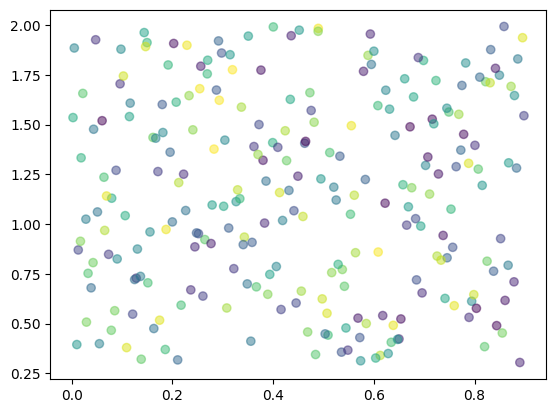

In [ ]:
# Experiment 1: CC
variables_to_sweep = {"y_0": (0, 0.9),
                      "tau": (0.3, 2.0),
                      "B_z_0": (5, 15),
                      "C_nm": (0.1, 2),
                      "noise_level": (0.01, 0.15)}

df_sample = create_lhs(variables_to_sweep, n_samples=250)
plt.scatter(df_sample["y_0"], df_sample["tau"], c=df_sample["B_z_0"], alpha=0.5)

df = sweep_cc_model_fitting(df_sample=df_sample, noise_type="gaussian", num_repeats=50, save_folder="cc_model_simple", save_name="lhs_50_repeats")

In [6]:
# Experiment 3: EC
variables_to_sweep = {"y_0": (0, 0.9),
                      "tau": (0.3, 2.0),
                      "B_z_0": (5, 15),
                      "C_nm": (0.1, 2),
                      "delta": (0.3, 1),
                      "psi": (1e-2, math.pi - 1e-2),
                      "noise_level": (0.01, 0.15)}

df_sample = create_lhs(variables_to_sweep, n_samples=500)

df = sweep_cc_model_fitting(df_sample=df_sample, noise_type="gaussian", num_repeats=25, save_folder="ec_model_simple", save_name="ec_model_lhs_25_repeats")

KeyboardInterrupt: 

In [7]:
# Test EC
variables_to_sweep = {"y_0": (0, 0.9),
                      "tau": (0.3, 2.0),
                      "B_z_0": (5, 15),
                      "C_nm": (0.1, 2),
                      "delta": (0.4, 1),
                      "psi": (1e-2, math.pi - 1e-2),
                      "noise_level": (0.01, 0.15)}

df_sample = create_lhs(variables_to_sweep, n_samples=500)
df = sweep_cc_model_fitting(df_sample=df_sample, noise_type="gaussian", num_repeats=50, save_folder="ec_model_simple", save_name="ec_model_lhs_50_repeats", num_time_stencil=13)

1 (1) noise = 4.5%: y_0 = 0.571/0.510, tau = 1.616/1.609, C_nm = 0.883/0.853, B_z_0 = 8.60/8.374, delta = 0.986/0.914, psi = 0.376/1.122 -> f_opt = 0.426
1 (2) noise = 4.5%: y_0 = 0.571/0.763, tau = 1.616/1.316, C_nm = 0.883/1.923, B_z_0 = 8.60/12.778, delta = 0.986/0.590, psi = 0.376/0.111 -> f_opt = 0.566
1 (3) noise = 4.5%: y_0 = 0.571/0.519, tau = 1.616/1.596, C_nm = 0.883/0.887, B_z_0 = 8.60/8.524, delta = 0.986/0.945, psi = 0.376/1.593 -> f_opt = 0.618
1 (4) noise = 4.5%: y_0 = 0.571/0.839, tau = 1.616/1.280, C_nm = 0.883/2.100, B_z_0 = 8.60/15.254, delta = 0.986/0.437, psi = 0.376/0.037 -> f_opt = 0.746
1 (5) noise = 4.5%: y_0 = 0.571/0.573, tau = 1.616/1.559, C_nm = 0.883/0.924, B_z_0 = 8.60/8.667, delta = 0.986/1.000, psi = 0.376/0.374 -> f_opt = 0.705
1 (6) noise = 4.5%: y_0 = 0.571/0.569, tau = 1.616/1.531, C_nm = 0.883/0.898, B_z_0 = 8.60/8.457, delta = 0.986/1.000, psi = 0.376/0.374 -> f_opt = 0.524
1 (7) noise = 4.5%: y_0 = 0.571/0.501, tau = 1.616/1.598, C_nm = 0.883/1.0

In [125]:
df_test = pd.read_csv("ec_model_simple/test_ec.csv")
df_test

f_opt  random_seed  noise_level  num_repeat  num_experiment       y_0  \
0  48.470641            0         0.05           1               1  0.439361   
1   0.970025            1         0.05           2               1  0.439361   
2   1.134092            2         0.05           3               1  0.439361   
3   1.243113            3         0.05           4               1  0.439361   
4   1.195611            4         0.05           5               1  0.439361   

    y_0_opt       tau   tau_opt      B_z_0  B_z_0_opt      C_nm  C_nm_opt  \
0  0.827069  0.384212  0.430426  13.558404  12.353812  0.197566  0.195850   
1  0.440660  0.384212  0.383472  13.558404  13.549172  0.197566  0.197728   
2  0.439321  0.384212  0.383698  13.558404  13.605761  0.197566  0.198539   
3  0.440199  0.384212  0.385560  13.558404  13.877626  0.197566  0.201511   
4  0.438321  0.384212  0.380963  13.558404  13.457209  0.197566  0.197693   

      delta  delta_opt      psi   psi_opt  
0  0.781718   0.863320  1.81014  2.517548  
1  0.781718   0.783235  1.81014  1.812177  
2  0.781718   0.781022  1.81014  1.812200  
3  0.781718   0.782850  1.81014  1.810085  
4  0.781718   0.780399  1.81014  1.808020

# Study 1: Varying noise level

In [ ]:
if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

df = sweep_cc_model_fitting(noise_levels=[0.01, 0.05, 0.1, 0.15],
                            y_0_range=ParameterRange(0, 0.8, 5),
                            tau_range=ParameterRange(0.5, 2.0, 4),
                            B_z_0_range=ParameterRange(5, 15, 3),
                            num_repeats=25,
                            save_folder=save_folder)

0: y_0 = 0.000, tau = 0.500, B_z_0 = 5.000 --> Opt. y_0 = 0.001, Opt. tau = 0.499, B_z_0 = 5.000, psi = 0.000 --> f_opt = 0.062
1: y_0 = 0.000, tau = 0.500, B_z_0 = 5.000 --> Opt. y_0 = -0.001, Opt. tau = 0.501, B_z_0 = 5.000, psi = 0.000 --> f_opt = 0.081
2: y_0 = 0.000, tau = 0.500, B_z_0 = 5.000 --> Opt. y_0 = -0.000, Opt. tau = 0.500, B_z_0 = 5.000, psi = 0.000 --> f_opt = 0.082
3: y_0 = 0.000, tau = 0.500, B_z_0 = 5.000 --> Opt. y_0 = 0.001, Opt. tau = 0.500, B_z_0 = 5.000, psi = 0.000 --> f_opt = 0.098
4: y_0 = 0.000, tau = 0.500, B_z_0 = 5.000 --> Opt. y_0 = -0.000, Opt. tau = 0.499, B_z_0 = 5.000, psi = 0.000 --> f_opt = 0.092
5: y_0 = 0.000, tau = 0.500, B_z_0 = 5.000 --> Opt. y_0 = 0.001, Opt. tau = 0.497, B_z_0 = 5.000, psi = 0.000 --> f_opt = 0.068
6: y_0 = 0.000, tau = 0.500, B_z_0 = 5.000 --> Opt. y_0 = -0.001, Opt. tau = 0.501, B_z_0 = 5.000, psi = 0.000 --> f_opt = 0.083
7: y_0 = 0.000, tau = 0.500, B_z_0 = 5.000 --> Opt. y_0 = 0.000, Opt. tau = 0.497, B_z_0 = 5.000, ps

<Axes: xlabel='time (h)', ylabel='$B$ (nT)'>

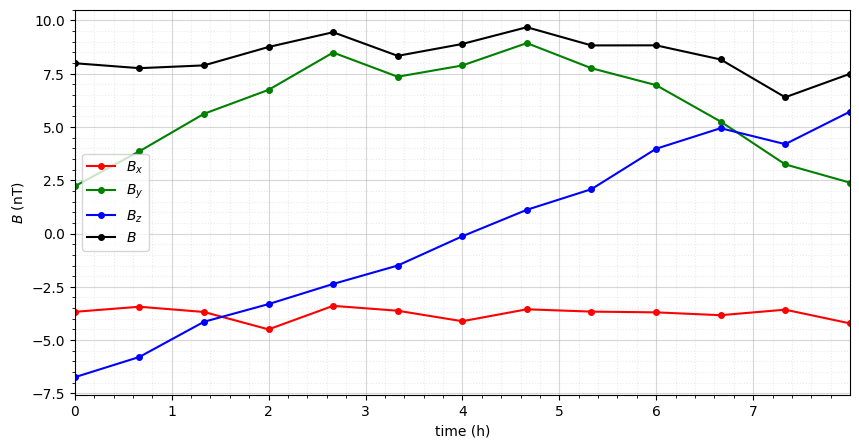

In [151]:
tau=1.3
B_z_0 = 10
y_0 = 0.5
noise_type = "gaussian"
noise_level = 0.05

my_ec_model = ECModel(delta=1, psi=0, tau=tau, B_z_0=B_z_0)
df_with_noise = my_ec_model.simulate_crossing(time_stencil=13, v_sc=450.0, y_0=y_0, noise_type=noise_type, epsilon=noise_level*my_ec_model.B_z_0, random_seed=1)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
my_ec_model.plot_vs_time(df_with_noise, ["B_x", "B_y", "B_z", "B"], colour=["r", "g", "b", "k"], time_units="h", ax=ax)

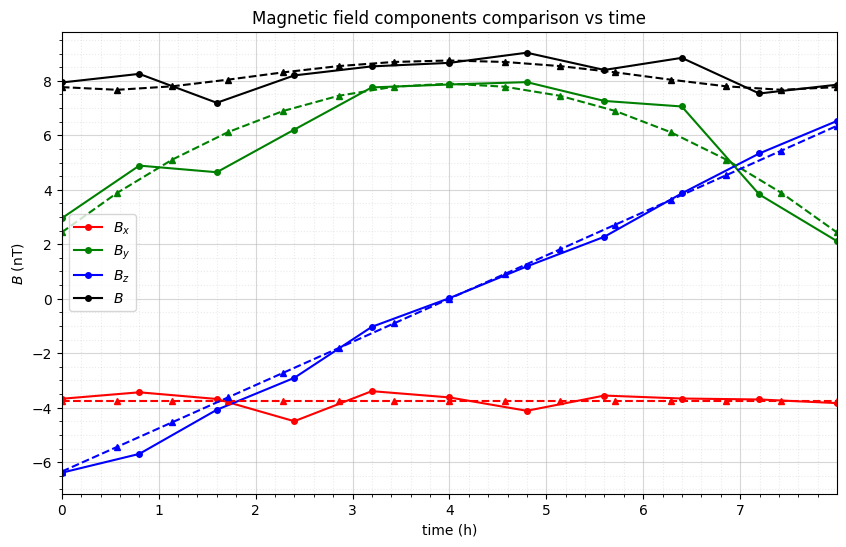

In [ ]:
model_params = {
    "delta": {"mode": "fixed", "value": 1.0},
    "psi": {"mode": "fixed", "value": 0.0},
    "tau": {"mode": "optimised", "initial_value": 1.4, "bounds": [0.1, 2.0]},
    "B_z_0": {"mode": "optimised", "initial_value": 8.0, "bounds": [1, 20]}
    }

crossing_params = {
    "y_0": {"mode": "optimised", "initial_value": 0.0, "bounds": [-0.95, 0.95]},
    "v_sc": {"mode": "fixed", "value": 450.0}
    }

# Simulate the crossing.
result = ECModel.fit(ECModel, df, model_params, crossing_params, residue_method="RMSE")
fitted_model, _, crossing_params_opt, df_fitted, optimisation_result = result

my_ec_model.plot_crossing_magnetic_difference(df_with_noise, df_fitted)

In [91]:
df = pd.read_csv("data4/all_noises_delta_95.csv")
df =  process_results(df)
magnitudes = ["delta", "y_0", "tau", "B_z_0", "psi"]

df_low_noise = df.loc[df["noise_level"] <= 0.05, :]

polynomials = dict()
for mag in magnitudes:
    polynomials[mag] = np.polyfit(x=df_low_noise["noise_level"], y=df_low_noise[f"{mag}_opt"], deg=2)

polynomials

{'delta': array([12.15770377,  0.45930141,  0.95016855]),
 'y_0': array([ 0.28918135, -0.0717058 ,  0.10009762]),
 'tau': array([-9.15459189, -0.49159977,  1.29995343]),
 'B_z_0': array([27.36735988,  1.19290409, 10.0004322 ]),
 'psi': array([ 4.21851765e+04, -1.92697421e+03,  3.29164811e+01])}

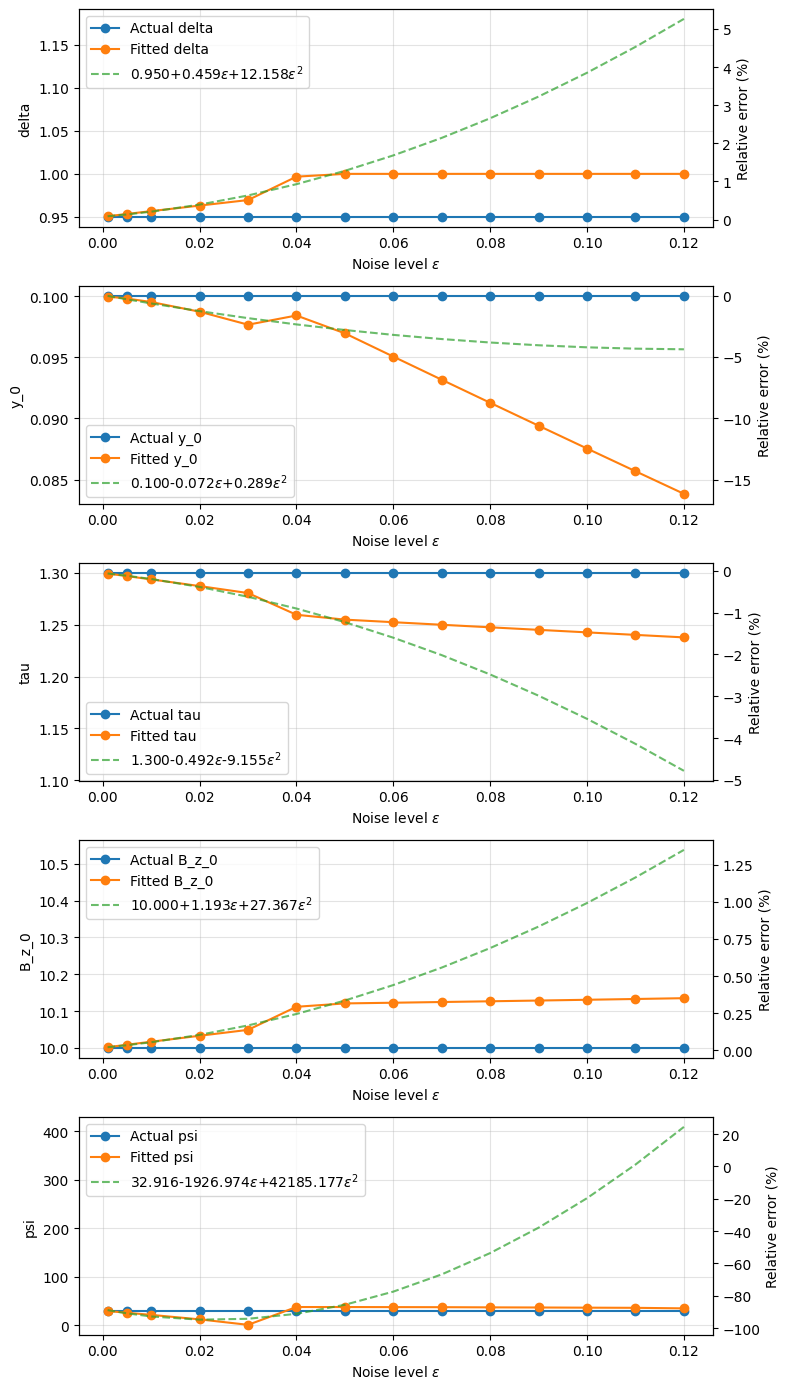

In [92]:
fig, ax = plt.subplots(len(magnitudes), 1, figsize=(8, 14), tight_layout=True)

for idx, mag in enumerate(magnitudes):
    # Left column.
    ax[idx].plot(df["noise_level"], df[mag], "-o", label=f"Actual {mag}")
    ax[idx].plot(df["noise_level"], df[f"{mag}_opt"], "-o", label=f"Fitted {mag}")

    poly = polynomials[mag]
    polynomial_fit = np.polyval(poly, df["noise_level"])

    poly_label = f"{poly[2]:.3f}"
    if poly[1] >= 0:
        poly_label += "+"
    poly_label += f"{poly[1]:.3f}$\\epsilon$"
    if poly[0] >= 0:
        poly_label += "+"
    poly_label += f"{poly[0]:.3f}$\\epsilon^2$"

    ax[idx].plot(df["noise_level"], polynomial_fit, "--", alpha=0.7, label=poly_label)

    ax[idx].set_xlabel(r"Noise level $\epsilon$")
    ax[idx].set_ylabel(mag)
    ax[idx].grid(alpha=0.35)
    ax[idx].legend()


    ax2 = ax[idx].twinx()
    ax2.plot(df["noise_level"], df[f"{mag}_rel_error"]*100, alpha=0)
    ax2.set_ylabel("Relative error (%)")

plt.show()

In [ ]:
save_folder: str = "data3"

if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

noise_levels: list[float] = [0.005] #, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]

for noise_level in noise_levels:
    df = sweep_ec_model_fitting(noise_level=noise_level,
                                    delta_range=ParameterRange(0.6, 0.95, 5),
                                    y_0_range=ParameterRange(0, 0.7, 5),
                                    tau_range=ParameterRange(0.5, 1.5, 4),
                                    B_z_0_range=ParameterRange(5, 15, 3),
                                    save_folder=save_folder)

Noise level = 0.0050.
0.5235987755982988
Delta = 0.600, y_0 = 0.000, tau = 0.500, B_z_0 = 5.000, psi = 0.524 --> Opt. delta = 0.543, Opt. y_0 = -0.000, Opt. tau = 0.553, B_z_0 = 5.000, psi = 1.321 --> f_opt = 0.002
0.5235987755982988
Delta = 0.600, y_0 = 0.000, tau = 0.500, B_z_0 = 10.000, psi = 0.524 --> Opt. delta = 0.601, Opt. y_0 = -0.000, Opt. tau = 0.501, B_z_0 = 10.000, psi = 0.521 --> f_opt = 0.006
0.5235987755982988
Delta = 0.600, y_0 = 0.000, tau = 0.500, B_z_0 = 15.000, psi = 0.524 --> Opt. delta = 0.543, Opt. y_0 = -0.000, Opt. tau = 0.553, B_z_0 = 15.000, psi = 1.321 --> f_opt = 0.014
0.5235987755982988
Delta = 0.600, y_0 = 0.000, tau = 0.833, B_z_0 = 5.000, psi = 0.524 --> Opt. delta = 0.601, Opt. y_0 = -0.000, Opt. tau = 0.834, B_z_0 = 5.000, psi = 0.520 --> f_opt = 0.002
0.5235987755982988
Delta = 0.600, y_0 = 0.000, tau = 0.833, B_z_0 = 10.000, psi = 0.524 --> Opt. delta = 0.601, Opt. y_0 = -0.000, Opt. tau = 0.834, B_z_0 = 10.000, psi = 0.520 --> f_opt = 0.006
0.52359

In [63]:
df = pd.read_csv("data3/sim_results_0.0050.csv")

def process_results(df: pd.DataFrame) -> pd.DataFrame:
    df["psi"] = np.rad2deg(df["psi"])
    df["psi_opt"] = np.rad2deg(df["psi_opt"])

    df["delta_error"] = df["delta_opt"] - df["delta"]
    df["y_0_error"] = df["y_0_opt"] - df["y_0"]
    df["tau_error"] = df["tau_opt"] - df["tau"]
    df["B_z_0_error"] = df["B_z_0_opt"] - df["B_z_0"]
    df["psi_error"] = df["psi_opt"] - df["psi"]

    df["delta_rel_error"] = df["delta_error"] / df["delta"]
    df["y_0_rel_error"] = df["y_0_error"] / df["y_0"]
    df["tau_rel_error"] = df["tau_error"] / df["tau"]
    df["B_z_0_rel_error"] = df["B_z_0_error"] / df["B_z_0"]
    df["psi_rel_error"] = df["psi_error"] / df["psi"]
    return df

df = process_results(df)
df.head()

delta  y_0       tau  B_z_0   psi  delta_opt   y_0_opt   tau_opt  \
0    0.6  0.0  0.500000    5.0  30.0   0.543153 -0.000085  0.552893   
1    0.6  0.0  0.500000   10.0  30.0   0.600858 -0.000108  0.500562   
2    0.6  0.0  0.500000   15.0  30.0   0.543153 -0.000085  0.552893   
3    0.6  0.0  0.833333    5.0  30.0   0.601432 -0.000180  0.834417   
4    0.6  0.0  0.833333   10.0  30.0   0.601433 -0.000180  0.834416   

   B_z_0_opt    psi_opt  ...  delta_error  y_0_error  tau_error  B_z_0_error  \
0   5.004276  75.714461  ...    -0.056847  -0.000085   0.052893     0.004276   
1  10.008571  29.871839  ...     0.000858  -0.000108   0.000562     0.008571   
2  15.012828  75.714451  ...    -0.056847  -0.000085   0.052893     0.012828   
3   5.004292  29.786621  ...     0.001432  -0.000180   0.001083     0.004292   
4  10.008587  29.786711  ...     0.001433  -0.000180   0.001083     0.008587   

   psi_error  delta_rel_error  y_0_rel_error  tau_rel_error  B_z_0_rel_error  \
0  45.714461        -0.094745           -inf       0.105786         0.000855   
1  -0.128161         0.001429           -inf       0.001125         0.000857   
2  45.714451        -0.094745           -inf       0.105786         0.000855   
3  -0.213379         0.002387           -inf       0.001300         0.000858   
4  -0.213289         0.002388           -inf       0.001300         0.000859   

   psi_rel_error  
0       1.523815  
1      -0.004272  
2       1.523815  
3      -0.007113  
4      -0.007110  

[5 rows x 21 columns]

In [5]:
df[df["f_opt"] > 0.5]

delta    y_0       tau  B_z_0   psi  delta_opt   y_0_opt   tau_opt  \
101  0.6875  0.525  0.833333   15.0  30.0   0.530619  0.345120  0.508864   
236  0.8625  0.700  1.166667   15.0  30.0   0.519913  0.400743  0.506631   

     B_z_0_opt    psi_opt      f_opt  delta_error  y_0_error  tau_error  \
101  10.599223  31.612783   8.536551    -0.156881  -0.179880  -0.324469   
236   9.004433  27.060541  14.143357    -0.342587  -0.299257  -0.660036   

     B_z_0_error  psi_error  delta_rel_error  y_0_rel_error  tau_rel_error  \
101    -4.400777   1.612783        -0.228191      -0.342629      -0.389363   
236    -5.995567  -2.939459        -0.397202      -0.427510      -0.565745   

     B_z_0_rel_error  
101        -0.293385  
236        -0.399704

In [6]:
df_filt = df[df["f_opt"] <= 0.5]

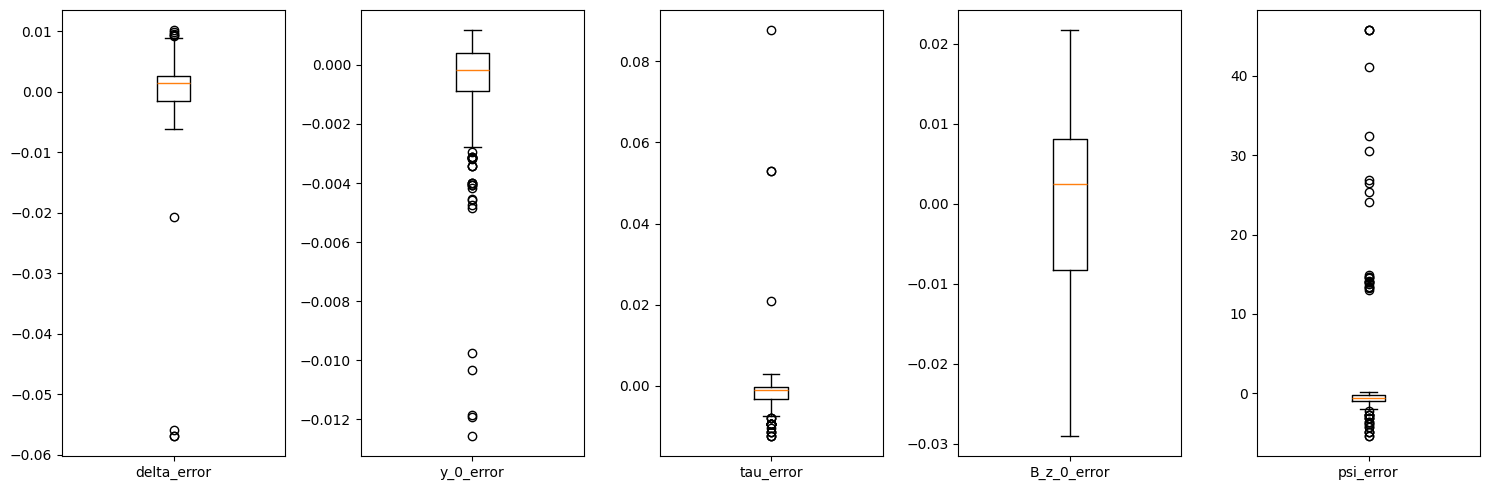

In [85]:
all_parameters = ["delta", "y_0", "tau", "B_z_0", "psi"]

fig, ax = plt.subplots(1,len(all_parameters), figsize=(15, 5), tight_layout=True)
for idx, param in enumerate(all_parameters):
    error_name = f"{param}_error"
    ax[idx].boxplot(df_filt[error_name])
    ax[idx].set_xticks([1])
    ax[idx].set_xticklabels([error_name])
plt.show()

In [43]:
df_delta_agg = df_filt.groupby("delta").std()
df_delta_agg

y_0       tau     B_z_0  psi  delta_opt   y_0_opt   tau_opt  \
delta                                                                      
0.6000  0.249576  0.375823  4.116935  0.0   0.012447  0.248418  0.371317   
0.6875  0.250649  0.378406  4.099151  0.0   0.003766  0.249773  0.376347   
0.7750  0.249576  0.375823  4.116935  0.0   0.002771  0.249209  0.374538   
0.8625  0.247415  0.378406  4.099151  0.0   0.002035  0.247603  0.377462   
0.9500  0.249576  0.375823  4.116935  0.0   0.002732  0.248180  0.374648   

        B_z_0_opt    psi_opt     f_opt  delta_error  y_0_error  tau_error  \
delta                                                                       
0.6000   4.114225  10.084583  0.005440     0.012447   0.001477   0.015793   
0.6875   4.097470   5.396675  0.005386     0.003766   0.001268   0.004595   
0.7750   4.115667   0.237883  0.005416     0.002771   0.000795   0.002505   
0.8625   4.100022   0.426630  0.005353     0.002035   0.000493   0.001239   
0.9500   4.117223  10.456542  0.005370     0.002732   0.003370   0.002385   

        B_z_0_error  psi_error  delta_rel_error  y_0_rel_error  tau_rel_error  \
delta                                                                           
0.6000     0.011039  10.084583         0.020744            NaN       0.024015   
0.6875     0.011626   5.396675         0.005478            NaN       0.006278   
0.7750     0.012115   0.237883         0.003576            NaN       0.001930   
0.8625     0.009360   0.426630         0.002359            NaN       0.000890   
0.9500     0.004642  10.456542         0.002876            NaN       0.001992   

        B_z_0_rel_error  
delta                    
0.6000         0.000991  
0.6875         0.001079  
0.7750         0.001115  
0.8625         0.000889  
0.9500         0.000708

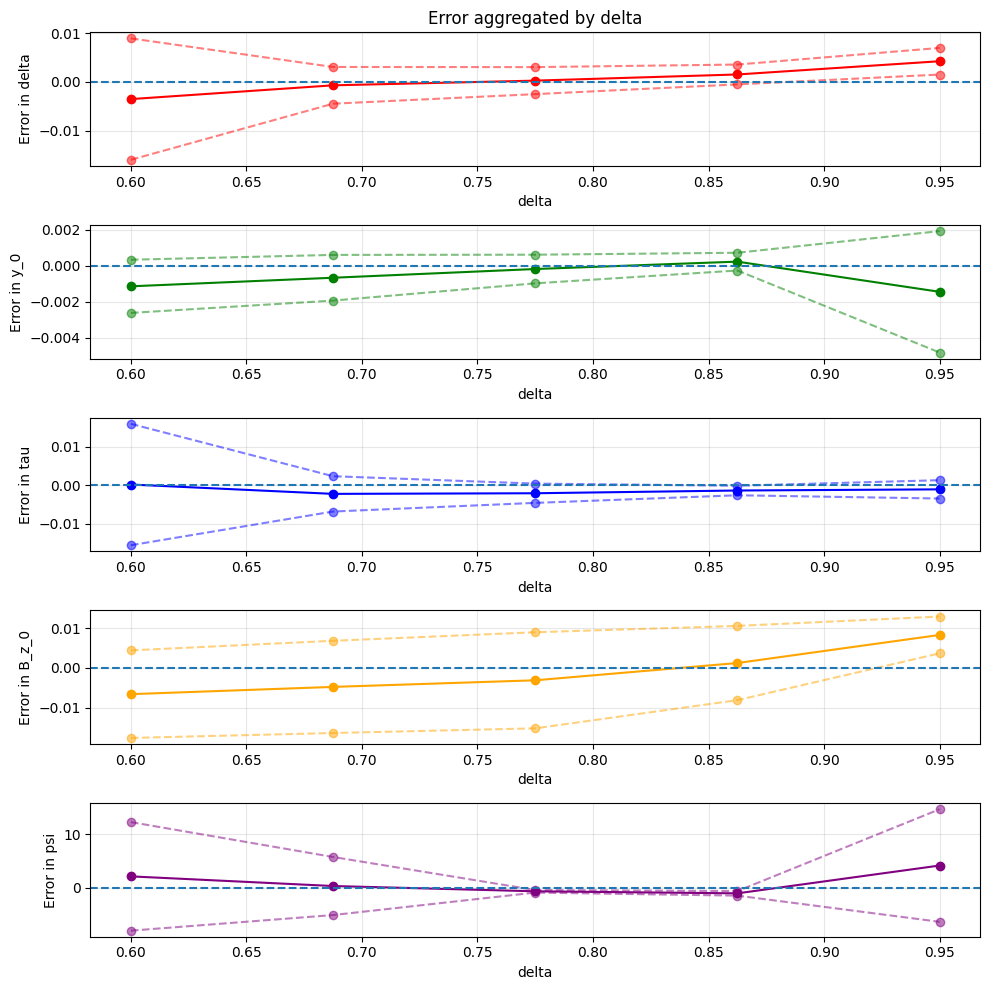

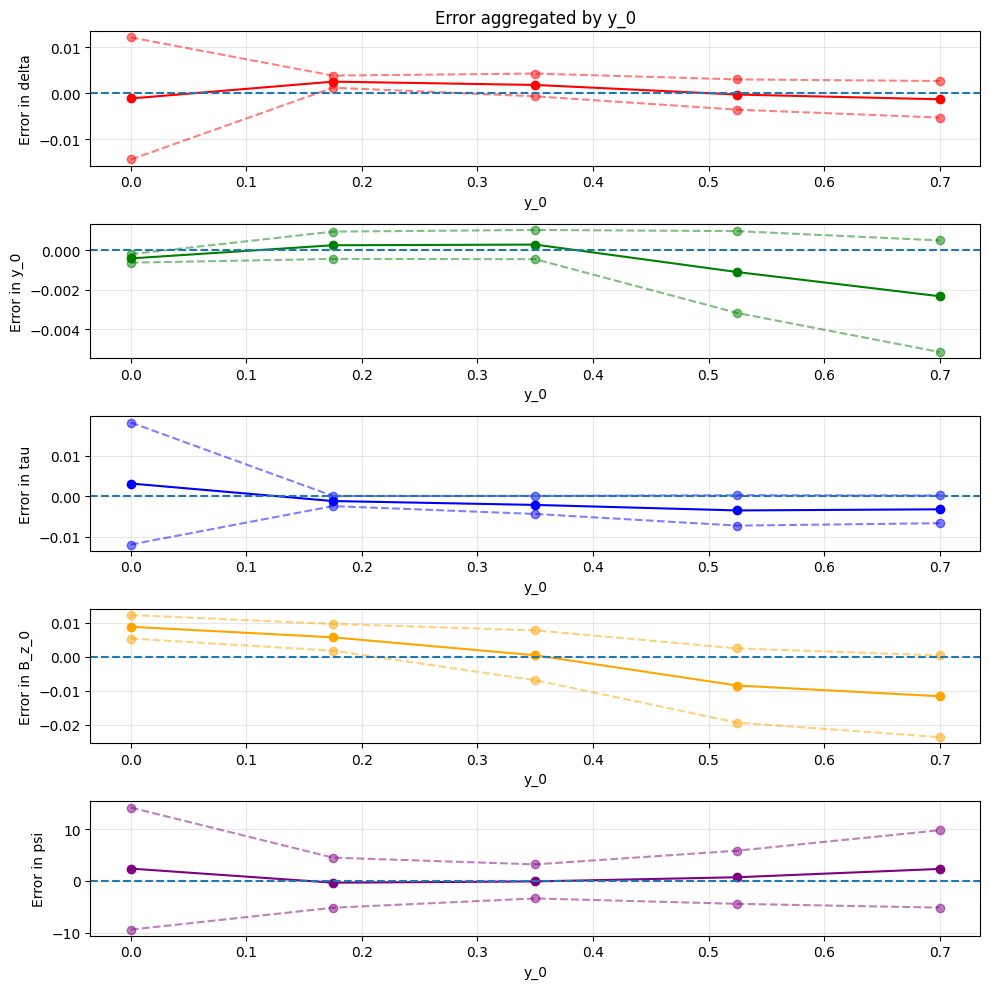

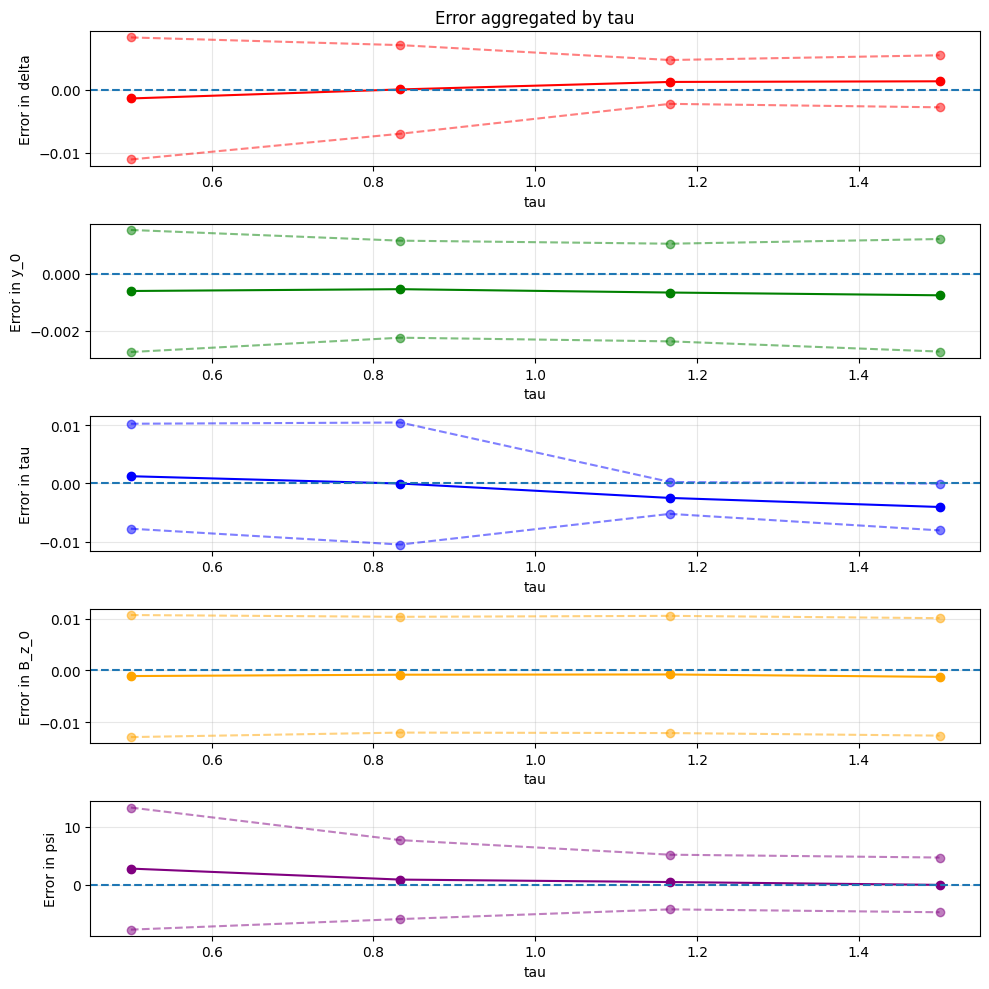

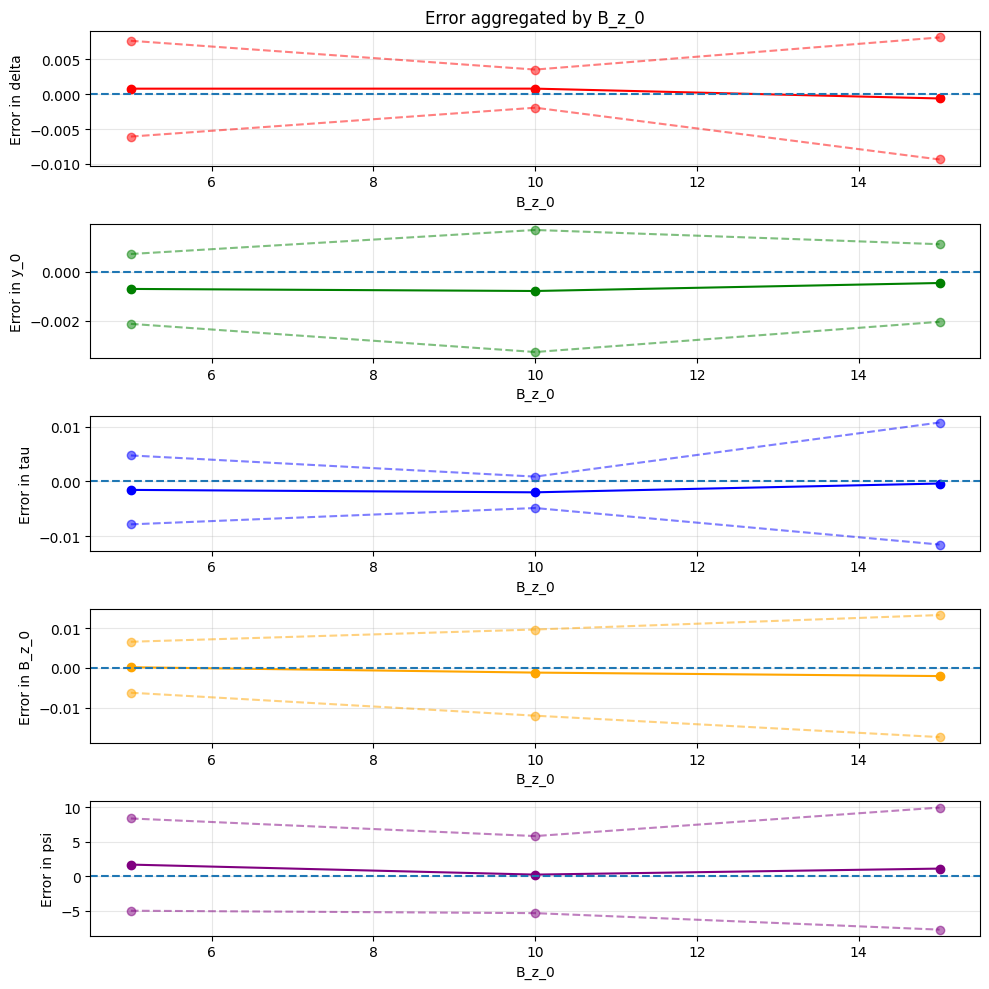

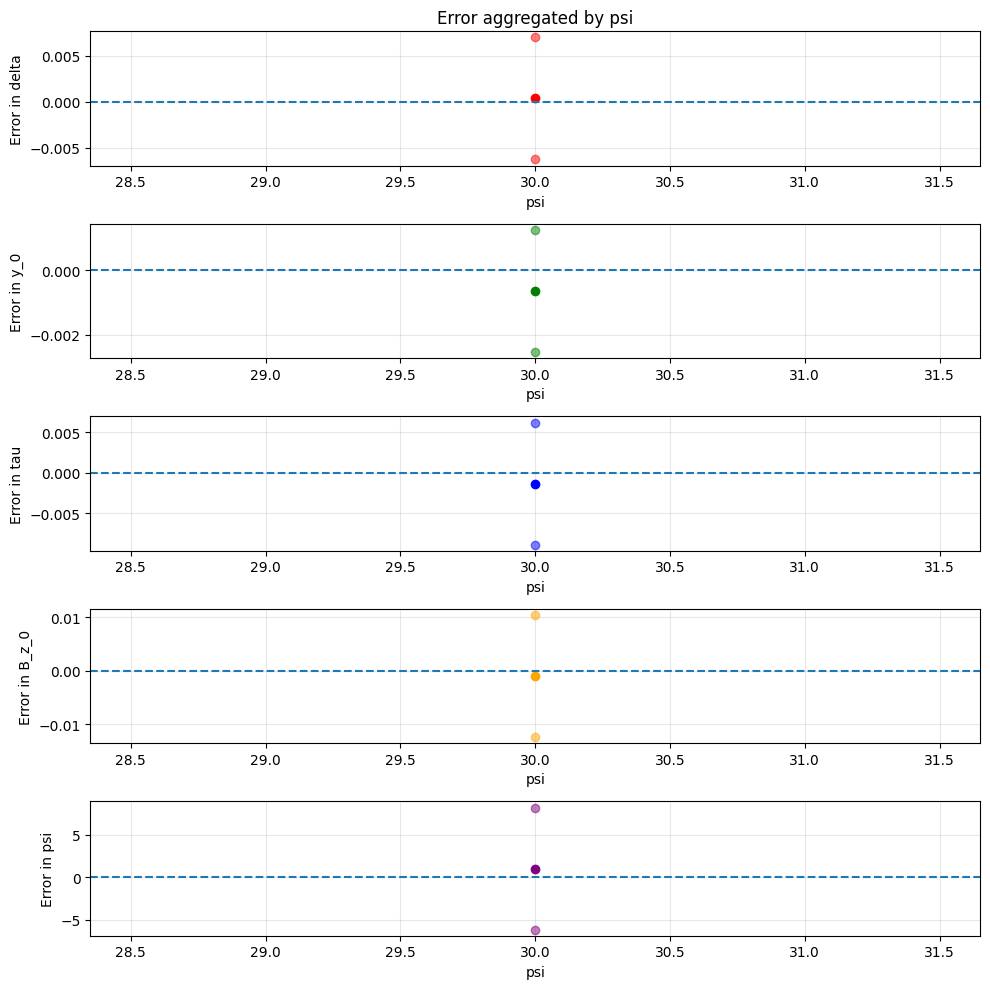

In [84]:
def plot_error_aggregates() -> None:
    all_parameters = ["delta", "y_0", "tau", "B_z_0", "psi"]
    colors = dict(zip(all_parameters, ["r", "g", "b", "orange", "purple"]))

    for parameter in all_parameters:
        df_agg = df_filt.groupby(parameter)
        df_agg_mean = df_agg.mean()
        df_agg_std = df_agg.std()
        
        fig, ax = plt.subplots(len(all_parameters), 1, tight_layout=True, figsize=(10, 10))


        for idx, a_param in enumerate(all_parameters):
            mean_error = df_agg_mean[f"{a_param}_error"]
            std_error = df_agg_std[f"{a_param}_error"]
            ax[idx].plot(df_agg_mean.index, mean_error, "-o", label=a_param, c=colors[a_param])
            ax[idx].plot(df_agg_mean.index, mean_error + std_error, "--o", c=colors[a_param], alpha=0.5)
            ax[idx].plot(df_agg_mean.index, mean_error - std_error, "--o", c=colors[a_param], alpha=0.5)
            ax[idx].axhline(0, linestyle="--")
            ax[idx].set_xlabel(parameter)
            ax[idx].set_ylabel(f"Error in {a_param}")
            ax[idx].grid(alpha=0.3)
        
        ax[0].set_title(f"Error aggregated by {parameter}")
        plt.show()

plot_error_aggregates()

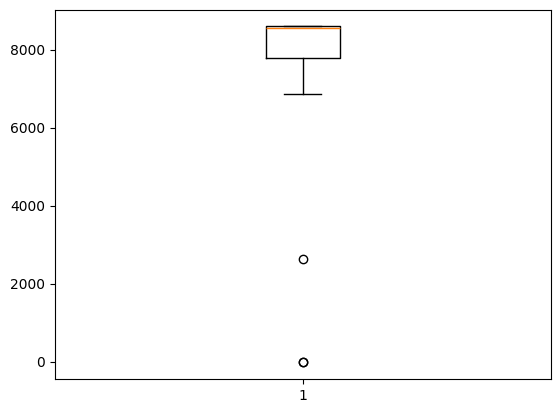

In [ ]:
plt.boxplot(np.rad2deg(df["psi_error"]))
plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/var/folders/q2/zrh3sz712dbc665prw9v99q80000gn/T/ipykernel_6222/2719748985.py:6: SyntaxWarning: invalid escape sequence '\d'
  labels = ["$\delta$", r"$\tau$", "$B_0^z$"]


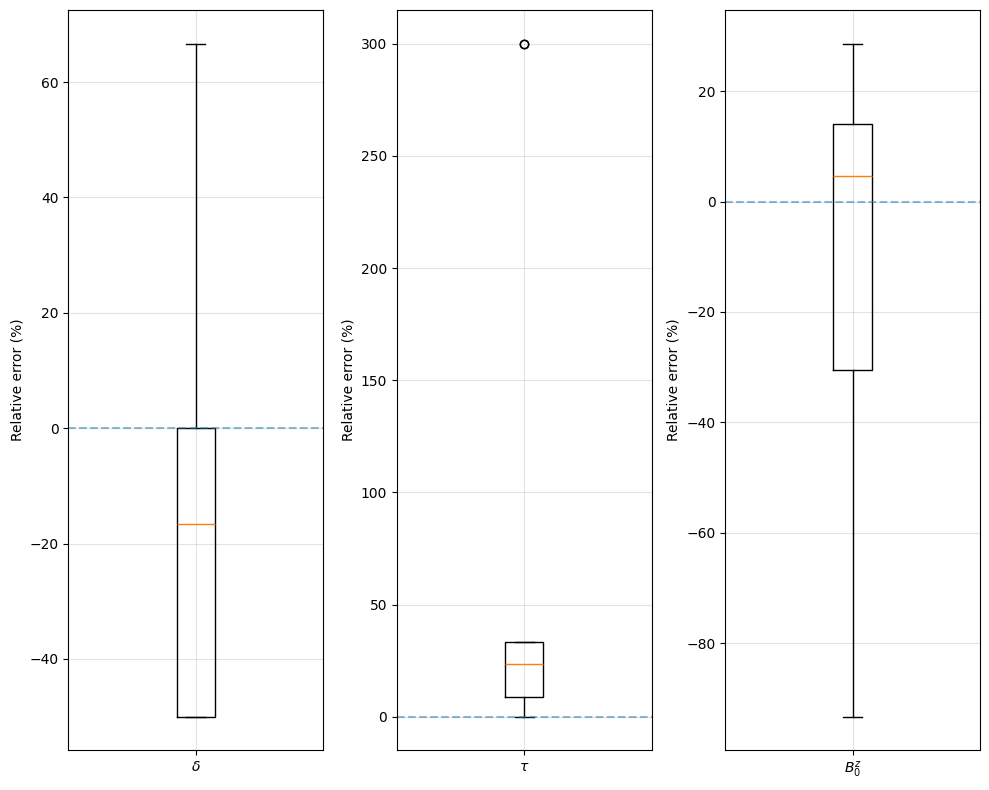

In [ ]:
fig, ax = plt.subplots(1, 3, tight_layout=True, figsize=(10, 8))
ax[0].boxplot(df["delta_rel_error"]*100)
ax[1].boxplot(df["tau_rel_error"]*100)
ax[2].boxplot(df["B_z_0_rel_error"]*100)

labels = ["$\delta$", r"$\tau$", "$B_0^z$"]
for ax_idx, label in enumerate(labels):
    ax[ax_idx].axhline(y=0, linestyle="--", alpha=0.5)
    ax[ax_idx].set_xticks(ticks=[1], labels=[label])
    ax[ax_idx].grid(alpha=0.35)
    ax[ax_idx].set_ylabel("Relative error (%)")
plt.show()

In [ ]:
df[np.abs(df["delta_error"]) > 0.01]


delta  y_0  tau  B_z_0   psi  delta_opt   y_0_opt   tau_opt  B_z_0_opt  \
0     0.6  0.0  0.5    5.0  30.0   0.543154 -0.000085  0.552892   5.004276   
2     0.6  0.0  1.5    5.0  30.0   1.000000 -0.002396  2.000000   3.425821   
4     0.6  0.8  0.5    5.0  30.0   0.500000  0.950000  0.618727   6.399387   
5     0.6  0.8  0.5   15.0  30.0   0.500000  0.950000  0.618727  19.198162   
6     0.6  0.8  1.5    5.0  30.0   0.500000  0.950000  1.586040   5.463321   
7     0.6  0.8  1.5   15.0  30.0   0.500000  0.950000  1.586041  16.389963   
8     1.0  0.0  0.5    5.0  30.0   0.500000 -0.950000  2.000000   1.427186   
12    1.0  0.8  0.5    5.0  30.0   0.500000  0.950000  0.646331   6.430070   
13    1.0  0.8  0.5   15.0  30.0   0.500000  0.950000  0.646331  19.290195   
14    1.0  0.8  1.5    5.0  30.0   0.500000  0.950000  1.652046   5.473580   
15    1.0  0.8  1.5   15.0  30.0   0.500000  0.950000  1.652046  16.420740   

       psi_opt       f_opt  delta_error  y_0_error  tau_error  B_z_0_error  \
0    75.714378    0.001602    -0.056846  -0.000085   0.052892     0.004276   
2   149.573573   14.657087     0.400000  -0.002396   0.500000    -1.574179   
4   179.433678    6.522994    -0.100000   0.150000   0.118727     1.399387   
5   179.433680   58.706943    -0.100000   0.150000   0.118727     4.198162   
6   179.447357    0.730196    -0.100000   0.150000   0.086040     0.463321   
7   179.447352    6.571766    -0.100000   0.150000   0.086041     1.389963   
8   171.045067   45.754509    -0.500000  -0.950000   1.500000    -3.572814   
12  180.000000   19.471462    -0.500000   0.150000   0.146331     1.430070   
13  180.000000  175.243158    -0.500000   0.150000   0.146331     4.290195   
14  180.000000    2.168972    -0.500000   0.150000   0.152046     0.473580   
15  180.000000   19.520748    -0.500000   0.150000   0.152046     1.420740   

     psi_error  delta_rel_error  y_0_rel_error  tau_rel_error  B_z_0_rel_error  
0    45.714378        -0.094743           -inf       0.105785         0.000855  
2   119.573573         0.666667           -inf       0.333333        -0.314836  
4   149.433678        -0.166667         0.1875       0.237454         0.279877  
5   149.433680        -0.166667         0.1875       0.237454         0.279877  
6   149.447357        -0.166667         0.1875       0.057360         0.092664  
7   149.447352        -0.166667         0.1875       0.057360         0.092664  
8   141.045067        -0.500000           -inf       3.000000        -0.714563  
12  150.000000        -0.500000         0.1875       0.292662         0.286014  
13  150.000000        -0.500000         0.1875       0.292662         0.286013  
14  150.000000        -0.500000         0.1875       0.101364         0.094716  
15  150.000000        -0.500000         0.1875       0.101364         0.094716

## Phase 2: Analysis of the results

Once the simulations are done, we proceed to read the results, format the data and create plots for interpretation.

### 2.1 Load the raw results and enrich the data

In [11]:
#data_filenames: list[str] = [f"{save_folder}/sim_results_{noise_level:.4f}.csv" for noise_level in noise_levels]

data_filenames = ["data/sim_results_0.0050.csv"]

dfs: list[pd.DataFrame] = []
for data_filename in data_filenames:
    df: pd.DataFrame = pd.read_csv(data_filename)
    df[df["delta_opt"] > 1e8] = 0
    df[df["y_0_opt"] > 1e8] = 0
    df["delta_difference"] = df["delta_opt"] - df["delta"]
    df["delta_difference_abs"] = np.abs(df["delta_difference"])
    df["y_0_difference"] = df["y_0_opt"] - df["y_0"]
    df["y_0_difference_abs"] = np.abs(df["y_0_difference"])
    df["combined_difference"] = np.sqrt(df["y_0_difference_abs"]**2 + df["delta_difference_abs"]**2)
    df["combined_difference_sat"] = np.maximum(df["combined_difference"], 1e-4)
    df["combined_difference_sat_log10"] = np.log10(df["combined_difference_sat"])
    df["success"] = df["combined_difference"] < 1e-3
    dfs.append(df)

### 2.2 Compute statistical aggregates for each noise level and plot them

In [12]:
stats: dict[str, np.ndarray] = {"rms_delta_error": [], "mean_absolute_delta_error": [], "std_delta_error": [],
                                "rms_y_0_error": [], "mean_absolute_y_0_error": [], "std_y_0_error": []}

for noise_level, df in zip(noise_levels, dfs):
    stats["rms_delta_error"].append(np.sqrt(np.mean(df["delta_difference"]**2)))
    stats["mean_absolute_delta_error"].append(np.mean(np.abs(df["delta_difference"])))
    stats["std_delta_error"].append(np.std(df["delta_difference"], ddof=1))
    stats["rms_y_0_error"].append(np.sqrt(np.mean(df["y_0_difference"]**2)))
    stats["mean_absolute_y_0_error"].append(np.mean(np.abs(df["y_0_difference"])))
    stats["std_y_0_error"].append(np.std(df["y_0_difference"], ddof=1))

for k, v in stats.items():
    stats[k] = np.array(v)

stats

NameError: name 'noise_levels' is not defined

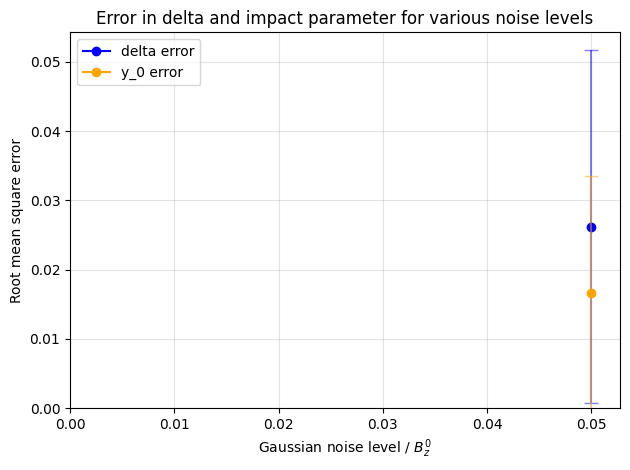

In [ ]:
fig, ax = plt.subplots(tight_layout=True)

ax.plot(noise_levels, stats["rms_delta_error"], "-o", label="delta error", color="b")
ax.errorbar(noise_levels, stats["rms_delta_error"], yerr=stats["std_delta_error"], color="b", capsize=5, alpha=0.5)

ax.plot(noise_levels, stats["rms_y_0_error"], "-o", label="y_0 error", color="orange")
ax.errorbar(noise_levels, stats["rms_y_0_error"], yerr=stats["std_y_0_error"], color="orange", capsize=5, alpha=0.5)

ax.grid(alpha=0.35)
ax.set_xlabel("Gaussian noise level / $B_z^0$")
ax.set_ylabel("Root mean square error")
ax.set_title("Error in delta and impact parameter for various noise levels")
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend()

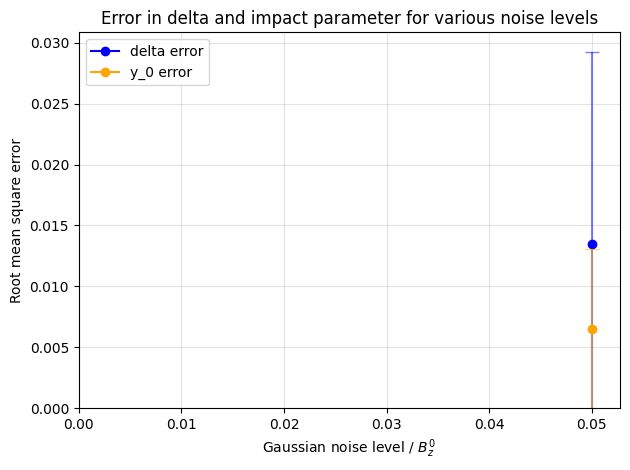

In [ ]:
fig, ax = plt.subplots(tight_layout=True)

ax.plot(noise_levels, stats["mean_absolute_delta_error"], "-o", label="delta error", color="b")
ax.errorbar(noise_levels, stats["mean_absolute_delta_error"], yerr=stats["std_delta_error"], color="b", capsize=5, alpha=0.5)

ax.plot(noise_levels, stats["mean_absolute_y_0_error"], "-o", label="y_0 error", color="orange")
ax.errorbar(noise_levels, stats["mean_absolute_y_0_error"], yerr=stats["std_y_0_error"], color="orange", capsize=5, alpha=0.5)

ax.grid(alpha=0.35)
ax.set_xlabel("Gaussian noise level / $B_z^0$")
ax.set_ylabel("Root mean square error")
ax.set_title("Error in delta and impact parameter for various noise levels")
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend()

### 2.3 Pivot the tables

The raw results consist of a dataframe for each noise level. The row of each dataframe represents one fitting, with their corresponding $\delta$ and $y_0$ values. We pivot this table to obtain a new table where the columns indicate $\delta$ and the rows $y_0$.

In [ ]:
pivot_dfs: list[pd.DataFrame] = []
for noise_level, df in zip(noise_levels, dfs):
    pivot_df = df.pivot(index="y_0", columns="delta", values="combined_difference_sat_log10")
    pivot_dfs.append(pivot_df)

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
cmap: LinearSegmentedColormap = LinearSegmentedColormap.from_list("rg",["g", "w", "r"], N=256)

num_experiments: int = len(noise_levels)
n_cols: int = 3
n_rows: int = num_experiments // n_cols

MIN_GLOBAL: float = 1e9
MAX_GLOBAL: float = -1e9

# Take min and max of all pivot dataframes to get the global extreme values.
for noise_level, matrix in zip(noise_levels, pivot_dfs):  
    matrix_min = np.min(matrix)
    matrix_max = np.max(matrix)

    MIN_GLOBAL = min(MIN_GLOBAL, matrix_min)
    MAX_GLOBAL = max(MAX_GLOBAL, matrix_max)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 12), tight_layout=True)

for ax_idx, (noise_level, matrix) in enumerate(zip(noise_levels, pivot_dfs)):
    y_0_range = matrix.index.to_list()
    delta_range = matrix.columns.to_list()
    Y_0, DELTA = np.meshgrid(delta_range, y_0_range)
    
    matrix_values = matrix.to_numpy()

    row_idx = ax_idx // n_cols
    col_idx = ax_idx % n_cols
    this_axis = ax[row_idx][col_idx]

    c = this_axis.pcolormesh(DELTA, Y_0, matrix_values, cmap=cmap, vmin=MIN_GLOBAL, vmax=MAX_GLOBAL) 
    this_axis.set_title(fr"Noise level $\epsilon$ = {noise_level:.3f}")
    this_axis.set_xlabel("$y_0$")
    this_axis.set_ylabel(r"$\delta$")
    fig.colorbar(c, ax=this_axis)

plt.suptitle("Combined error (log10)")
plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1200x1200 with 0 Axes>

In [ ]:
df = dfs[0]

fig, ax = plt.subplots(tight_layout=True)

for idx in range(len(df)):
    origin = [df.loc["delta", idx], df.loc["y_0", idx]]
    end  = [df.loc["delta_opt", idx], df.loc["y_0_opt", idx]]
    dx = end[0] - origin[0]
    dy = end[1] - origin[1]
    
    plt.arrow(origin[0], origin[1], dx, dy, head_width=0.2, head_length=0.3, fc='blue', ec='blue')


ax.grid(alpha=0.35)
ax.set_title(fr"Noise level $\epsilon$ = {noise_level:.3f}")
ax.set_xlabel("$y_0$")
ax.set_ylabel(r"$\delta$")


NameError: name 'dfs' is not defined

/var/folders/q2/zrh3sz712dbc665prw9v99q80000gn/T/ipykernel_25605/1891154716.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(index=pd.cut(df['b'], bins=20),
/var/folders/q2/zrh3sz712dbc665prw9v99q80000gn/T/ipykernel_25605/1891154716.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(index=pd.cut(df['b'], bins=20),


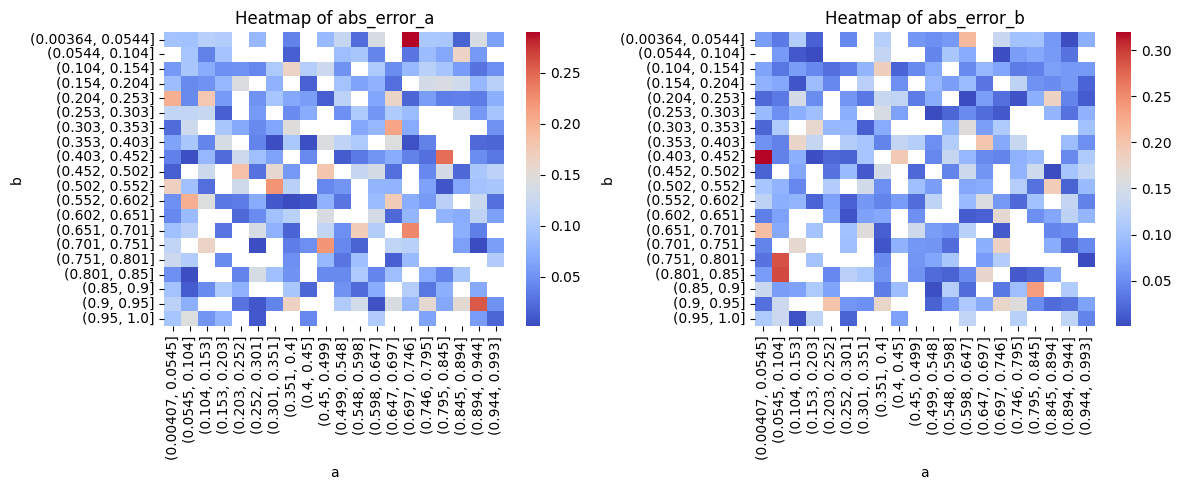

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (replace with your actual data)
np.random.seed(42)
num_samples = 500
a = np.random.rand(num_samples)
b = np.random.rand(num_samples)
a_pred = a + np.random.normal(0, 0.1, num_samples)  # Simulating prediction errors
b_pred = b + np.random.normal(0, 0.1, num_samples)

# Compute absolute errors
abs_error_a = np.abs(a_pred - a)
abs_error_b = np.abs(b_pred - b)

# Create a DataFrame
df = pd.DataFrame({'a': a, 'b': b, 'abs_error_a': abs_error_a, 'abs_error_b': abs_error_b})

# Plot heatmaps using binning
plt.figure(figsize=(12, 5))
for i, col in enumerate(['abs_error_a', 'abs_error_b']):
    plt.subplot(1, 2, i + 1)
    pivot_table = df.pivot_table(index=pd.cut(df['b'], bins=20), 
                                 columns=pd.cut(df['a'], bins=20), 
                                 values=col, aggfunc='mean')
    sns.heatmap(pivot_table, cmap='coolwarm', cbar=True)
    plt.title(f'Heatmap of {col}')

plt.tight_layout()
plt.show()


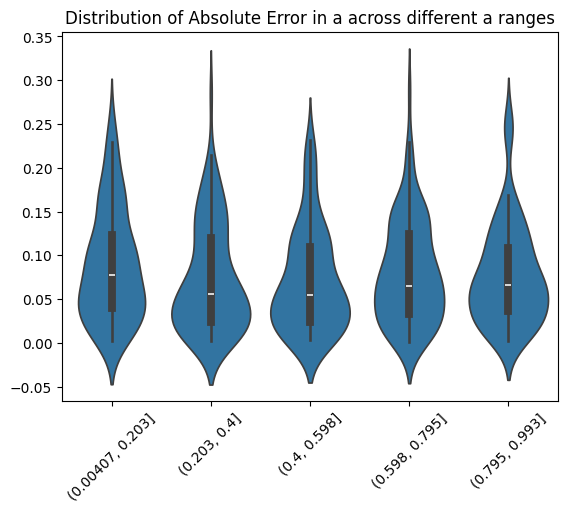

In [ ]:
sns.violinplot(x=pd.cut(a, bins=5), y=abs_error_a)
plt.xticks(rotation=45)
plt.title("Distribution of Absolute Error in a across different a ranges")
plt.show()

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Simulated data: 6D space
np.random.seed(42)
num_samples = 10000
df = pd.DataFrame({
    'a': np.random.rand(num_samples),
    'b': np.random.rand(num_samples),
    'c': np.random.rand(num_samples),
    'd': np.random.rand(num_samples),
    'e': np.random.rand(num_samples),
    'f': np.random.rand(num_samples),
    'a_pred': np.random.rand(num_samples),
    'b_pred': np.random.rand(num_samples),
})

# Compute absolute errors
df['abs_error_a'] = np.abs(df['a_pred'] - df['a'])
df['abs_error_b'] = np.abs(df['b_pred'] - df['b'])

# Slice space (fixing c, d, e, f at their median values)
df_slice = df[
    (df['c'].between(0.45, 0.55)) & 
    (df['d'].between(0.45, 0.55)) &
    (df['e'].between(0.45, 0.55)) &
    (df['f'].between(0.45, 0.55))
]

# Create a heatmap of abs_error_a in (a, b) space
heatmap_data = df_slice.pivot_table(index=pd.cut(df_slice['b'], bins=20), 
                                    columns=pd.cut(df_slice['a'], bins=20), 
                                    values='abs_error_a', aggfunc='mean')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', cbar=True)
plt.title("Absolute Error in a across (a, b) subspace")
plt.xlabel("a")
plt.ylabel("b")
plt.show()


ValueError: Cannot cut empty array

In [27]:
from pandas.plotting import parallel_coordinates

df_sample = df.sample(500)  # Reduce number of points for visualization
df_sample['error_a'] = np.abs(df_sample['a_pred'] - df_sample['a'])

plt.figure(figsize=(10, 6))
parallel_coordinates(df_sample[['a', 'b', 'c', 'd', 'e', 'f', 'error_a']], class_column='error_a', colormap='coolwarm')
plt.title("Parallel Coordinates Plot")
plt.show()


KeyError: 'a_pred'